In [1]:
# ========================
# Базовые библиотеки
# ========================
import os
import json

# ========================
# Научные библиотеки
# ========================
import numpy as np
import pandas as pd

# ========================
# Визуализация
# ========================
import matplotlib.pyplot as plt
import seaborn as sns

# ========================
# Машинное обучение / предобработка
# ========================
from sklearn.model_selection import train_test_split
from scipy.interpolate import griddata

# ========================
# PyTorch (если используется)
# ========================
import torch


Summary statistics for selected features and target:
               X_int          Y_int            Ang           Mean
count  151392.000000  151392.000000  151392.000000  151392.000000
mean        4.031250       3.093750      90.000000      -0.257766
std         2.567648       1.958312      54.772437       0.497797
min         0.000000       0.000000       0.000000      -1.593751
25%         2.000000       1.750000      40.000000      -0.597377
50%         4.000000       3.000000      90.000000      -0.455263
75%         6.000000       5.000000     140.000000       0.104503
max         8.000000       6.000000     180.000000       0.952414


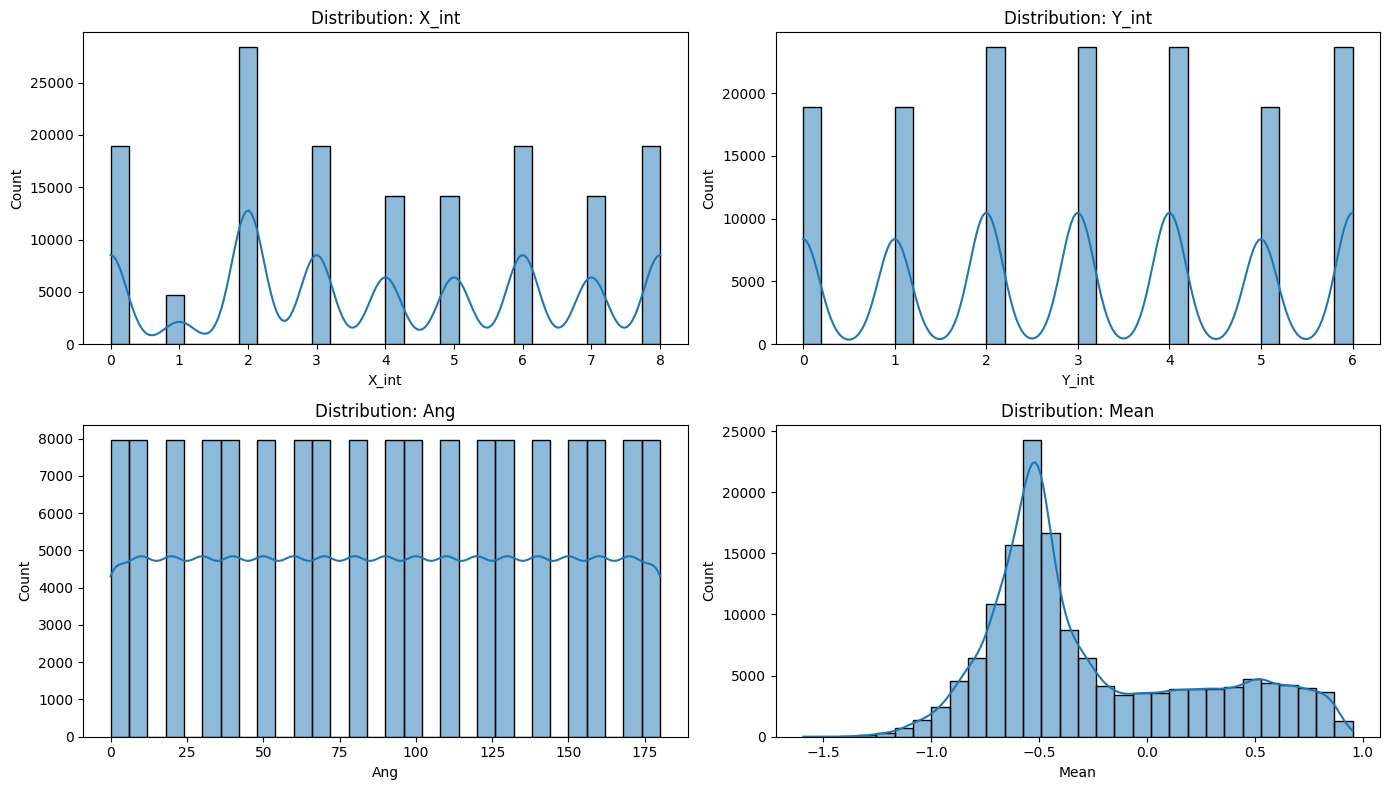


Outlier counts using IQR method:
X_int: 0 outliers
Y_int: 0 outliers
Ang: 0 outliers
Mean: 0 outliers


In [2]:
# ✅ Specify actual path to your CSV file
file_path = "/mnt/d/projects/wind_pressure_prediction_CNN/data/processed/windloading_interference_base.csv"

# Load data
df = pd.read_csv(file_path)

# Select features and target
features = ['X_int', 'Y_int', 'Ang']
target = 'Mean'
df_subset = df[features + [target]]

# Summary statistics
print("Summary statistics for selected features and target:")
print(df_subset.describe())

# Plot distributions
plt.figure(figsize=(14, 8))
for i, column in enumerate(features + [target]):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df_subset[column], kde=True, bins=30)
    plt.title(f'Distribution: {column}')
    plt.xlabel(column)
    plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Outlier detection using IQR method
print("\nOutlier counts using IQR method:")
for col in features + [target]:
    Q1 = df_subset[col].quantile(0.25)
    Q3 = df_subset[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_subset[(df_subset[col] < lower_bound) | (df_subset[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers")


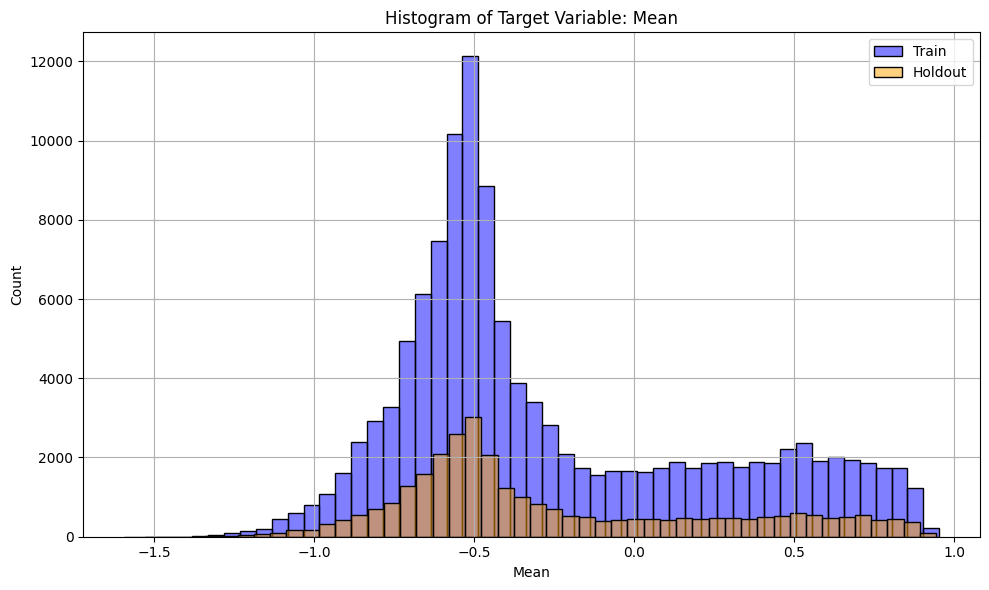

Mean and Standard Deviation of Target (Mean):
         Train   Holdout
Mean -0.258191 -0.256064
Std   0.497945  0.497211

Number of samples in each dataset:
Full dataset (df):     151392
Training set (train):  121113
Holdout set:           30279


In [3]:
# Split the dataset
train_df, holdout_df = train_test_split(df, test_size=0.2, random_state=42)

# File paths
train_path = "/mnt/d/projects/wind_pressure_prediction_CNN/data/processed/windloading_interference_train.csv"
holdout_path = "/mnt/d/projects/wind_pressure_prediction_CNN/data/holdout/windloading_interference_holdout.csv"

# Save the datasets
train_df.to_csv(train_path, index=False)
holdout_df.to_csv(holdout_path, index=False)

# Features to compare
features = ['X_int', 'Y_int', 'Ang', 'Mean']

# Histogram comparison for target variable "Mean"
plt.figure(figsize=(10, 6))
sns.histplot(train_df["Mean"], label="Train", color='blue', bins=50, alpha=0.5)
sns.histplot(holdout_df["Mean"], label="Holdout", color='orange', bins=50, alpha=0.5)
plt.title("Histogram of Target Variable: Mean")
plt.xlabel("Mean")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Mean and standard deviation for target in both sets
mean_std_comparison = pd.DataFrame({
    "Train": {
        "Mean": train_df["Mean"].mean(),
        "Std": train_df["Mean"].std()
    },
    "Holdout": {
        "Mean": holdout_df["Mean"].mean(),
        "Std": holdout_df["Mean"].std()
    }
})

print("Mean and Standard Deviation of Target (Mean):")
print(mean_std_comparison)
print()

# Sample counts
print("Number of samples in each dataset:")
print(f"Full dataset (df):     {len(df)}")
print(f"Training set (train):  {len(train_df)}")
print(f"Holdout set:           {len(holdout_df)}")


In [4]:
print(df[['X_fac', 'Y_fac']].describe())


               X_fac          Y_fac
count  151392.000000  151392.000000
mean       14.425703       4.991968
std         8.089604       2.594399
min         1.000000       1.000000
25%         7.000000       3.000000
50%        14.000000       5.000000
75%        21.000000       7.000000
max        28.000000       9.000000


In [5]:
# ========================
# Load training data
# ========================
train_path = "/mnt/d/projects/wind_pressure_prediction_CNN/data/processed/windloading_interference_train.csv"
train_df = pd.read_csv(train_path)

# ========================
# Найти строки с пропущенными значениями Mean
# ========================
nan_df = train_df[train_df['Mean'].isna()]

# ========================
# Вывести результаты
# ========================
if nan_df.empty:
    print("✅ No NaN values found in 'Mean' column.")
else:
    print(f"⚠️ Found {len(nan_df)} rows with NaN in 'Mean':")
    display_cols = ['X_int', 'Y_int', 'Ang', 'X_fac', 'Y_fac', 'Mean']
    print(nan_df[display_cols].to_string(index=False))


✅ No NaN values found in 'Mean' column.


In [6]:
# ========================
# Load training data
# ========================
train_path = "/mnt/d/projects/wind_pressure_prediction_CNN/data/processed/windloading_interference_train.csv"
train_df = pd.read_csv(train_path)

# ========================
# Define grid resolution
# ========================

# Grid size (facade resolution)
Nx, Ny = 28, 9

# Convert facade coordinates to grid indices (starting from 0)
train_df["X_idx"] = train_df["X_fac"].astype(int) - 1
train_df["Y_idx"] = train_df["Y_fac"].astype(int) - 1

# ========================
# Utility functions
# ========================

def get_missing_facade_indices(train_df, Nx, Ny):
    """Return a list of grid indices that are missing in the dataset."""
    all_indices = set((x, y) for y in range(Ny) for x in range(Nx))
    present_indices = set(zip(train_df["X_idx"], train_df["Y_idx"]))
    missing_indices = all_indices - present_indices
    return list(missing_indices)

def fill_missing_with_interpolation(grid):
    """
    Заполняет пропущенные значения (NaN) в пределах строк (Y),
    учитывая деление по фасадам: [0-6], [7-13], [14-20], [21-27].
    Значения рассчитываются как среднее между ближайшими по X (горизонтали) в пределах одного фасада.
    """
    grid_filled = grid.copy()
    Ny, Nx = grid.shape

    # Границы фасадов (индексы в Python с нуля)
    facade_ranges = [(0, 6), (7, 13), (14, 20), (21, 27)]

    for y in range(Ny):
        for facade_start, facade_end in facade_ranges:
            for x in range(facade_start, facade_end + 1):
                if np.isnan(grid_filled[y, x]):
                    left = None
                    right = None

                    # Поиск слева в пределах текущего фасада
                    for lx in range(x - 1, facade_start - 1, -1):
                        if not np.isnan(grid_filled[y, lx]):
                            left = grid_filled[y, lx]
                            break

                    # Поиск справа в пределах текущего фасада
                    for rx in range(x + 1, facade_end + 1):
                        if not np.isnan(grid_filled[y, rx]):
                            right = grid_filled[y, rx]
                            break

                    # Заполнение по найденным значениям
                    if left is not None and right is not None:
                        grid_filled[y, x] = (left + right) / 2
                    elif left is not None:
                        grid_filled[y, x] = left
                    elif right is not None:
                        grid_filled[y, x] = right
                    else:
                        grid_filled[y, x] = 0.0  # ничего не нашли

    return grid_filled



# ========================
# Prepare CNN training data
# ========================

group_cols = ['X_int', 'Y_int', 'Ang']
groups = train_df.groupby(group_cols)

X_list = []
Y_list = []

interpolation_log = []

for group_key, group_data in groups:
    # Initialize an empty grid
    grid = np.full((Ny, Nx), np.nan)

    # Fill grid with known mean pressure values
    for _, row in group_data.iterrows():
        x, y = int(row["X_idx"]), int(row["Y_idx"])
        grid[y, x] = row["Mean"]  # Row = Y, Column = X

    # Detect missing values before interpolation
    missing_mask = np.isnan(grid)
    interpolated_indices = list(zip(*np.where(missing_mask)))

    # Log missing points
    for (y, x) in interpolated_indices:
        interpolation_log.append({
            "X_int": group_key[0],
            "Y_int": group_key[1],
            "Ang": group_key[2],
            "X_idx": x,
            "Y_idx": y
        })

    '''if interpolated_indices:
        print(f"🔧 Interpolated {len(interpolated_indices)} missing values at: {interpolated_indices}")
    '''

    # Interpolate missing values
    igrid = fill_missing_with_interpolation(grid)

    # Save processed data
    X_int, Y_int, Ang = group_key

    X_grid = np.full((Ny, Nx), X_int)
    Y_grid = np.full((Ny, Nx), Y_int)
    Ang_grid = np.full((Ny, Nx), Ang)

    X_tensor = np.stack([X_grid, Y_grid, Ang_grid], axis=0)  # → (3, 9, 28)
    X_list.append(X_tensor)



    Y_tensor = igrid[np.newaxis, :, :]  # → (1, 9, 28)
    Y_list.append(Y_tensor)


# ========================
# Save processed data
# ========================

# Define save directory
save_dir = "/mnt/d/projects/wind_pressure_prediction_CNN/data/processed/cnn_input"
os.makedirs(save_dir, exist_ok=True)

# Save interpolation log
if interpolation_log:
    log_df = pd.DataFrame(interpolation_log)
    log_path = os.path.join(save_dir, "interpolation_log.csv")
    log_df.to_csv(log_path, index=False)
    print(f"📄 Interpolation log saved to: {log_path}")

# Convert to numpy arrays
X_cnn = np.array(X_list)  # → (N, 3, 9, 28)
Y_cnn = np.array(Y_list)  # → (N, 1, 9, 28)


# Save arrays
np.save(os.path.join(save_dir, "X_cnn.npy"), X_cnn)
np.save(os.path.join(save_dir, "Y_cnn.npy"), Y_cnn)

# Save grid metadata
grid_info = {"Nx": Nx, "Ny": Ny, "description": "Grid resolution used for CNN training data"}
with open(os.path.join(save_dir, "grid_info.json"), "w") as f:
    json.dump(grid_info, f, indent=4)

# ========================
# Summary
# ========================
print("✅ CNN training data prepared and saved.")
print(f"📁 Directory: {save_dir}")
print(f"📐 X_cnn shape (params): {X_cnn.shape}")
print(f"🧱 Y_cnn shape (grids):  {Y_cnn.shape}")


📄 Interpolation log saved to: /mnt/d/projects/wind_pressure_prediction_CNN/data/processed/cnn_input/interpolation_log.csv
✅ CNN training data prepared and saved.
📁 Directory: /mnt/d/projects/wind_pressure_prediction_CNN/data/processed/cnn_input
📐 X_cnn shape (params): (608, 3, 9, 28)
🧱 Y_cnn shape (grids):  (608, 1, 9, 28)


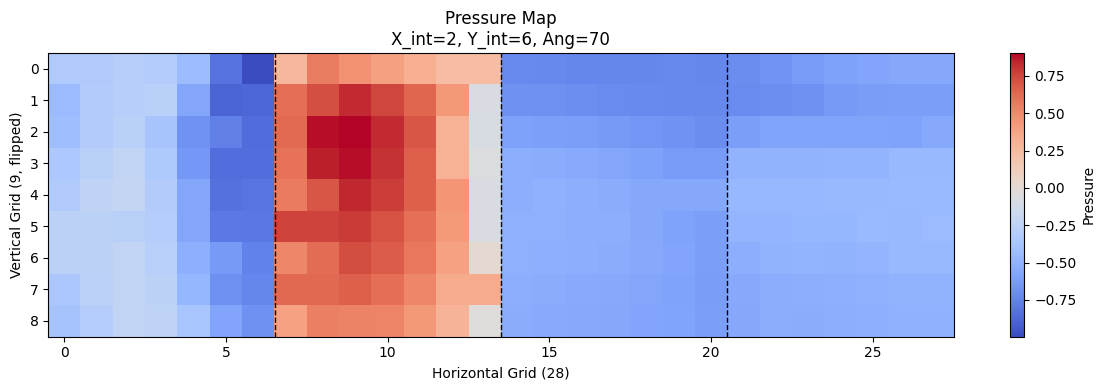

In [13]:
def plot_pressure_map_with_facade_division(X, Y, x_int, y_int, ang):
    """
    Визуализация карты давления с перевёрнутой осью Y и пунктирными линиями между фасадами.
    Разделение по горизонтали: между колонками 7-8, 14-15, 21-22.
    """
    # Используем np.isclose для сравнения с плавающей точкой
    mask = (X[:, 0] == x_int) & (X[:, 1] == y_int) & (np.isclose(X[:, 2], ang))
    indices = np.where(mask)[0]

    if len(indices) == 0:
        print(f"❌ Нет данных для: X_int={x_int}, Y_int={y_int}, Ang={ang}")
        return

    idx = indices[0]
    pressure_map = Y[idx][0]

    plt.figure(figsize=(12, 4))
    plt.imshow(pressure_map[::-1], cmap='coolwarm', aspect='auto')
    plt.colorbar(label="Pressure")

    for col in [6.5, 13.5, 20.5]:
        plt.axvline(x=col, color='black', linestyle='--', linewidth=1)

    plt.title(f"Pressure Map\nX_int={x_int}, Y_int={y_int}, Ang={ang}")
    plt.xlabel("Horizontal Grid (28)")
    plt.ylabel("Vertical Grid (9, flipped)")
    plt.tight_layout()
    plt.show()

# Тестовая визуализация с разделением фасадов
plot_pressure_map_with_facade_division(X_cnn, Y_cnn, x_int=2, y_int=6, ang=70)


In [ ]:
# 📌 Перераспределение датасета по уникальным Case_ID

# Ранее train и holdout пересекались по Case_ID, что приводило к утечке информации при обучении:
# модель могла "вспоминать" данные из holdout, так как видела аналогичные случаи в трейне.

# В этом коде мы сначала создаём уникальные идентификаторы Case_ID на основе X_int, Y_int, Ang,
# а затем делаем честное разделение: train и holdout содержат непересекающиеся Case_ID.

# Таким образом, holdout содержит только те случаи, которые модель не видела во время обучения.
# Это обеспечивает объективную оценку качества модели.

# В завершение — сохраняем все файлы с индексами, чтобы обеспечить однозначную идентификацию строк.


📈 Summary statistics for selected features and target:
               X_int          Y_int            Ang           Mean
count  151392.000000  151392.000000  151392.000000  151392.000000
mean        4.031250       3.093750      90.000000      -0.257766
std         2.567648       1.958312      54.772437       0.497797
min         0.000000       0.000000       0.000000      -1.593751
25%         2.000000       1.750000      40.000000      -0.597377
50%         4.000000       3.000000      90.000000      -0.455263
75%         6.000000       5.000000     140.000000       0.104503
max         8.000000       6.000000     180.000000       0.952414


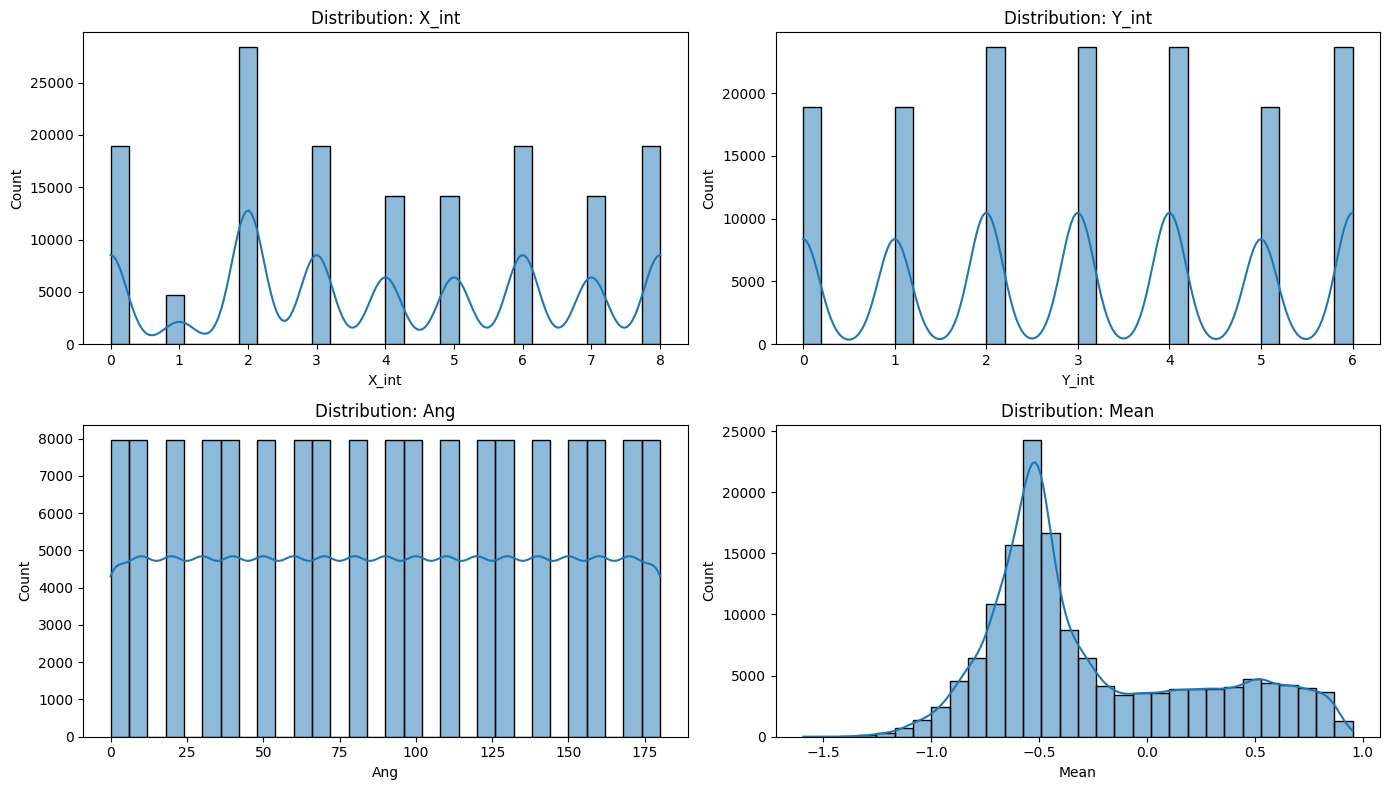


📦 Outlier counts using IQR method:
X_int: 0 outliers
Y_int: 0 outliers
Ang: 0 outliers
Mean: 0 outliers

🆔 Пример Case_ID:
   X_int  Y_int  Ang Case_ID
0      8      6    0   8_6_0
1      8      6   10  8_6_10
2      8      6   20  8_6_20
3      8      6   30  8_6_30
4      8      6   40  8_6_40

🔍 Пересечений Case_ID между train и holdout: 0

✅ Данные сохранены:
Train → /mnt/d/projects/wind_pressure_prediction_CNN/data/processed/windloading_interference_train_case_id.csv (121014 строк, 486 Case_ID)
Holdout → /mnt/d/projects/wind_pressure_prediction_CNN/data/holdout/windloading_interference_holdout_case_id.csv (30378 строк, 122 Case_ID)
Полный датасет с Case_ID → /mnt/d/projects/wind_pressure_prediction_CNN/data/processed/windloading_case_id.csv


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# ✅ Путь к CSV-файлу
file_path = "/mnt/d/projects/wind_pressure_prediction_CNN/data/processed/windloading_interference_base.csv"

# 📥 Загрузка данных
df = pd.read_csv(file_path)

# ✅ Признаки и целевая переменная
features = ['X_int', 'Y_int', 'Ang']
target = 'Mean'

# ✅ Добавление Case_ID на основе комбинации признаков
df["Case_ID"] = (
    df["X_int"].astype(str) + "_" +
    df["Y_int"].astype(str) + "_" +
    df["Ang"].astype(str)
)

# ✅ Подмножество с интересующими столбцами
df_subset = df[features + [target, "Case_ID"]]

# 📊 Статистика по данным
print("📈 Summary statistics for selected features and target:")
print(df_subset.describe())

# 📊 Визуализация распределений
plt.figure(figsize=(14, 8))
for i, column in enumerate(features + [target]):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df_subset[column], kde=True, bins=30)
    plt.title(f'Distribution: {column}')
    plt.xlabel(column)
    plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ⚠️ Поиск выбросов методом IQR
print("\n📦 Outlier counts using IQR method:")
for col in features + [target]:
    Q1 = df_subset[col].quantile(0.25)
    Q3 = df_subset[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_subset[(df_subset[col] < lower_bound) | (df_subset[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers")

# 👁 Быстрый просмотр Case_ID
print("\n🆔 Пример Case_ID:")
print(df_subset[["X_int", "Y_int", "Ang", "Case_ID"]].head())

# ✅ Разделение по уникальным Case_ID
unique_case_ids = df["Case_ID"].unique()
train_ids, holdout_ids = train_test_split(unique_case_ids, test_size=0.2, random_state=42)

df_train = df[df["Case_ID"].isin(train_ids)].copy()
df_holdout = df[df["Case_ID"].isin(holdout_ids)].copy()

# 📊 Проверка пересечения
overlap = set(df_train["Case_ID"]).intersection(set(df_holdout["Case_ID"]))
print(f"\n🔍 Пересечений Case_ID между train и holdout: {len(overlap)}")  # должно быть 0

# 💾 Сохранение датасетов
train_path = "/mnt/d/projects/wind_pressure_prediction_CNN/data/processed/windloading_interference_train_case_id.csv"
holdout_path = "/mnt/d/projects/wind_pressure_prediction_CNN/data/holdout/windloading_interference_holdout_case_id.csv"
full_with_id_path = "/mnt/d/projects/wind_pressure_prediction_CNN/data/processed/windloading_case_id.csv"

df_train.to_csv(train_path, index=False)
df_holdout.to_csv(holdout_path, index=False)
df.to_csv(full_with_id_path, index=False)

print("\n✅ Данные сохранены:")
print(f"Train → {train_path} ({len(df_train)} строк, {df_train['Case_ID'].nunique()} Case_ID)")
print(f"Holdout → {holdout_path} ({len(df_holdout)} строк, {df_holdout['Case_ID'].nunique()} Case_ID)")
print(f"Полный датасет с Case_ID → {full_with_id_path}")


In [33]:
import pandas as pd

# 📂 Пути к файлам
train_path = "/mnt/d/projects/wind_pressure_prediction_CNN/data/processed/windloading_interference_train_case_id.csv"
holdout_path = "/mnt/d/projects/wind_pressure_prediction_CNN/data/holdout/windloading_interference_holdout_case_id.csv"
file_path = "/mnt/d/projects/wind_pressure_prediction_CNN/data/processed/windloading_case_id.csv"

df = pd.read_csv(file_path)

# 📥 Загрузка файлов
df_train = pd.read_csv(train_path)
df_holdout = pd.read_csv(holdout_path)

# 🆔 Добавление Case_ID
df_train["Case_ID"] = (
    df_train["X_int"].astype(str) + "_" +
    df_train["Y_int"].astype(str) + "_" +
    df_train["Ang"].astype(str)
)

df_holdout["Case_ID"] = (
    df_holdout["X_int"].astype(str) + "_" +
    df_holdout["Y_int"].astype(str) + "_" +
    df_holdout["Ang"].astype(str)
)

# 📊 Подсчёт уникальных Case_ID
unique_train = set(df_train["Case_ID"].unique())
unique_holdout = set(df_holdout["Case_ID"].unique())
unique_only_in_holdout = unique_holdout - unique_train

# 📋 Таблица с информацией
summary = pd.DataFrame({
    "Set": ["Train", "Holdout", "Unique_Case_IDs_Only_in_Holdout"],
    "Rows": [len(df_train), len(df_holdout), len(unique_only_in_holdout)],
    "Unique_Case_IDs": [df_train["Case_ID"].nunique(), df_holdout["Case_ID"].nunique(), len(unique_only_in_holdout)]
})

print(summary)

# 💾 Перезапись файлов с индексами
df_train.to_csv(train_path, index=True)
df_holdout.to_csv(holdout_path, index=True)

print("✅ Датасеты обновлены и перезаписаны с Case_ID и индексами:")
print(f"→ Train:   {train_path}")
print(f"→ Holdout: {holdout_path}")


                               Set    Rows  Unique_Case_IDs
0                            Train  121014              486
1                          Holdout   30378              122
2  Unique_Case_IDs_Only_in_Holdout     122              122
✅ Датасеты обновлены и перезаписаны с Case_ID и индексами:
→ Train:   /mnt/d/projects/wind_pressure_prediction_CNN/data/processed/windloading_interference_train_case_id.csv
→ Holdout: /mnt/d/projects/wind_pressure_prediction_CNN/data/holdout/windloading_interference_holdout_case_id.csv


In [34]:
import os
import json
import numpy as np
import pandas as pd

# ========================
# Пути
# ========================

train_grid_dir = "/mnt/d/projects/wind_pressure_prediction_CNN/data/processed/cnn_input_case_id"
holdout_grid_dir = "/mnt/d/projects/wind_pressure_prediction_CNN/data/holdout/cnn_input_case_id"

os.makedirs(train_grid_dir, exist_ok=True)
os.makedirs(holdout_grid_dir, exist_ok=True)

# ========================
# Grid параметры
# ========================

Nx, Ny = 28, 9

# ========================
# Интерполяция
# ========================

def fill_missing_with_interpolation(grid):
    grid_filled = grid.copy()
    facade_ranges = [(0, 6), (7, 13), (14, 20), (21, 27)]
    for y in range(Ny):
        for start, end in facade_ranges:
            for x in range(start, end + 1):
                if np.isnan(grid_filled[y, x]):
                    left = right = None
                    for lx in range(x - 1, start - 1, -1):
                        if not np.isnan(grid_filled[y, lx]):
                            left = grid_filled[y, lx]
                            break
                    for rx in range(x + 1, end + 1):
                        if not np.isnan(grid_filled[y, rx]):
                            right = grid_filled[y, rx]
                            break
                    grid_filled[y, x] = (
                        (left + right) / 2 if left is not None and right is not None
                        else left if left is not None
                        else right if right is not None
                        else 0.0
                    )
    return grid_filled

# ========================
# CNN-препроцессинг
# ========================

def prepare_cnn_data(df: pd.DataFrame, save_dir: str, tag: str):
    df["X_idx"] = df["X_fac"].astype(int) - 1
    df["Y_idx"] = df["Y_fac"].astype(int) - 1
    groups = df.groupby("Case_ID")

    X_list, Y_list, interpolation_log = [], [], []

    for case_id, group in groups:
        grid = np.full((Ny, Nx), np.nan)
        for _, row in group.iterrows():
            x, y = int(row["X_idx"]), int(row["Y_idx"])
            grid[y, x] = row["Mean"]

        # Логируем недостающие значения
        missing = np.isnan(grid)
        for y, x in zip(*np.where(missing)):
            interpolation_log.append({
                "Case_ID": case_id,
                "X_idx": x,
                "Y_idx": y
            })

        # Интерполяция
        igrid = fill_missing_with_interpolation(grid)

        X_int, Y_int, Ang = map(float, case_id.split("_"))
        X_grid = np.full((Ny, Nx), X_int)
        Y_grid = np.full((Ny, Nx), Y_int)
        Ang_grid = np.full((Ny, Nx), Ang)

        X_tensor = np.stack([X_grid, Y_grid, Ang_grid], axis=0)   # (3, 9, 28)
        Y_tensor = igrid[np.newaxis, :, :]                        # (1, 9, 28)

        X_list.append(X_tensor)
        Y_list.append(Y_tensor)

    X_cnn = np.array(X_list)
    Y_cnn = np.array(Y_list)

    np.save(os.path.join(save_dir, "X_cnn.npy"), X_cnn)
    np.save(os.path.join(save_dir, "Y_cnn.npy"), Y_cnn)

    if interpolation_log:
        pd.DataFrame(interpolation_log).to_csv(os.path.join(save_dir, "interpolation_log.csv"), index=False)

    with open(os.path.join(save_dir, "grid_info.json"), "w") as f:
        json.dump({"Nx": Nx, "Ny": Ny}, f, indent=4)

    print(f"✅ {tag.upper()} CNN data saved:")
    print(f"   📐 X_cnn shape: {X_cnn.shape}, Y_cnn shape: {Y_cnn.shape}")
    print(f"   📁 Saved to: {save_dir}")
    return len(X_list)

# ========================
# Загрузка и формирование Case_ID
# ========================

df_train["Case_ID"] = (
    df_train["X_int"].astype(str) + "_" +
    df_train["Y_int"].astype(str) + "_" +
    df_train["Ang"].astype(str)
)

df_holdout["Case_ID"] = (
    df_holdout["X_int"].astype(str) + "_" +
    df_holdout["Y_int"].astype(str) + "_" +
    df_holdout["Ang"].astype(str)
)

# ========================
# Проверка уникальности
# ========================

unique_train = set(df_train["Case_ID"])
unique_holdout = set(df_holdout["Case_ID"])
overlap = unique_train.intersection(unique_holdout)

summary = pd.DataFrame({
    "Set": ["Train", "Holdout", "Unique_Holdout_Only"],
    "Rows": [len(df_train), len(df_holdout), len(unique_holdout - unique_train)],
    "Unique Case_IDs": [len(unique_train), len(unique_holdout), len(unique_holdout - unique_train)],
})

print("\n📊 Case_ID Summary:")
print(summary)
print(f"\n⚠️ Пересечений Case_ID между train и holdout: {len(overlap)}")

# ========================
# Сохранение CSV с индексами
# ========================

df_train.to_csv(train_path, index=True)
df_holdout.to_csv(holdout_path, index=True)

# ========================
# Построение гридов
# ========================

n_train = prepare_cnn_data(df_train, train_grid_dir, tag="train_case_id")
n_holdout = prepare_cnn_data(df_holdout, holdout_grid_dir, tag="holdout_case_id")

# ========================
# Финальный лог
# ========================

print(f"\n📦 Гридов сформировано:")
print(f"Train:   {n_train} (уникальных Case_ID: {df_train['Case_ID'].nunique()})")
print(f"Holdout: {n_holdout} (уникальных Case_ID: {df_holdout['Case_ID'].nunique()})")
print(f"✅ Done.")



📊 Case_ID Summary:
                   Set    Rows  Unique Case_IDs
0                Train  121014              486
1              Holdout   30378              122
2  Unique_Holdout_Only     122              122

⚠️ Пересечений Case_ID между train и holdout: 0
✅ TRAIN_CASE_ID CNN data saved:
   📐 X_cnn shape: (486, 3, 9, 28), Y_cnn shape: (486, 1, 9, 28)
   📁 Saved to: /mnt/d/projects/wind_pressure_prediction_CNN/data/processed/cnn_input_case_id
✅ HOLDOUT_CASE_ID CNN data saved:
   📐 X_cnn shape: (122, 3, 9, 28), Y_cnn shape: (122, 1, 9, 28)
   📁 Saved to: /mnt/d/projects/wind_pressure_prediction_CNN/data/holdout/cnn_input_case_id

📦 Гридов сформировано:
Train:   486 (уникальных Case_ID: 486)
Holdout: 122 (уникальных Case_ID: 122)
✅ Done.


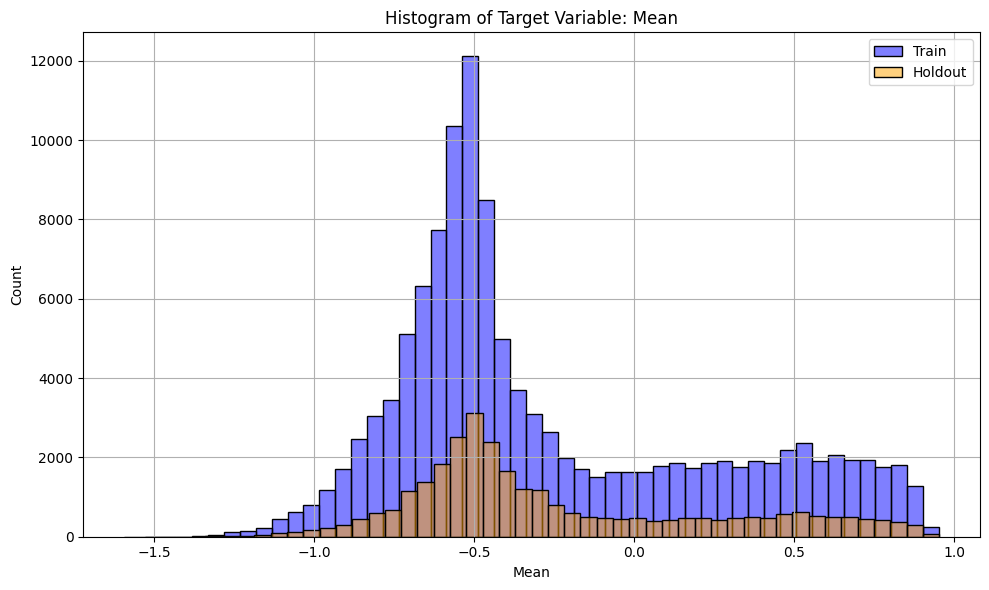

Mean and Standard Deviation of Target (Mean):
         Train   Holdout
Mean -0.258191 -0.256064
Std   0.497945  0.497211

Number of samples in each dataset:
Full dataset (df):     151392
Training set (train):  121014
Holdout set:           30378


In [35]:
# Features to compare
features = ['X_int', 'Y_int', 'Ang', 'Mean']

# Histogram comparison for target variable "Mean"
plt.figure(figsize=(10, 6))
sns.histplot(df_train["Mean"], label="Train", color='blue', bins=50, alpha=0.5)
sns.histplot(df_holdout["Mean"], label="Holdout", color='orange', bins=50, alpha=0.5)
plt.title("Histogram of Target Variable: Mean")
plt.xlabel("Mean")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Mean and standard deviation for target in both sets
mean_std_comparison = pd.DataFrame({
    "Train": {
        "Mean": train_df["Mean"].mean(),
        "Std": train_df["Mean"].std()
    },
    "Holdout": {
        "Mean": holdout_df["Mean"].mean(),
        "Std": holdout_df["Mean"].std()
    }
})

print("Mean and Standard Deviation of Target (Mean):")
print(mean_std_comparison)
print()

# Sample counts
print("Number of samples in each dataset:")
print(f"Full dataset (df):     {len(df)}")
print(f"Training set (train):  {len(df_train)}")
print(f"Holdout set:           {len(df_holdout)}")
